In [13]:
# !pip install openTSNE==1.0.0
# !pip install numpy==1.23.5

In [14]:
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import numpy as np

import h5py
from openTSNE import TSNE
from copy import deepcopy

# 恢复所有参数到默认值
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams.update({'legend.fontsize': 14})
def plot(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=False,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    output_name=None,
    **kwargs
):
    import matplotlib

    if ax is None:
        fig, ax = matplotlib.pyplot.subplots(figsize=(6, 5))
        
    if title is not None:
        ax.set_title(title)

    #plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}
    plot_params = {"alpha": kwargs.get("alpha", 0.8)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = matplotlib.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    # print(colors.get(y[0]))
    point_colors = list(map(colors.get, y))

    size = deepcopy(y)
    point_size = deepcopy(y)
    point_size[size != 1] = 1
    point_size[size == 1] = 50
    point_size[size == 2] = 1
    
    # fig=ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, s=point_size,**plot_params)
    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, s=5,**plot_params)
    
    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label+': '+str(len(x)),
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=20,
                alpha=1.,
                linewidth=0,
                label = str(yi)+': '+str(len(y[y ==yi])),
                
                # markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="lower right", bbox_to_anchor=(0.95, 0.05), frameon=False, labelspacing=0.9)
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)
    plt.show()
    
    if output_name:
        fig.savefig(output_name, dpi=600, format='pdf', bbox_inches='tight')
    return fig

In [15]:
def tsne(feat,labels,**kwargs):
    #label = get_label(coords,anno_file,_l)
    embedding = TSNE(n_jobs=8).fit(feat)
    return plot(embedding,labels,**kwargs)

In [16]:
import torch
from model import MIL_MTL
from dataloader import GcDataset
import numpy as np
from torch.utils.data import DataLoader, RandomSampler

In [17]:
def tsne_abmil(feat_dir, cpt_path, input_dim, **kwargs):
    p, l = [], []
    label_path = '../datatools/gc/n-labels/test_label.csv'
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            p.append(line.split(',')[0])
            l.append(line.split(',')[1])
    p = np.array(p)
    l = np.array(l)
    test_set = GcDataset(p,l,root=feat_dir, persistence=False, keep_same_psize=False, num_classes=5, high_weight=1.0, is_train=False)
    big_seed_list = 7784414403328510413
    generator = torch.Generator()
    generator.manual_seed(big_seed_list)  
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1,generator=generator)

    _dis_abmil = MIL_MTL(input_dim=input_dim, num_classes=[5], num_task=1, mil='abmil').eval().requires_grad_(False)
    dis_cpt = torch.load(cpt_path)
    _dis_abmil.load_state_dict(dis_cpt['model'], strict=False)
    _dis_abmil.cuda()

    # inference
    feats = []
    labels = []
    for f, l, p in test_loader:
        f = f.cuda()
        f = _dis_abmil.forward_feat(f)
        feats.append(f)
        labels.append(l.item())
        
    feats = torch.cat(feats, dim=0)
    labels = np.array(labels)
    tsne(feats.cpu().numpy(), labels, **kwargs)
    return

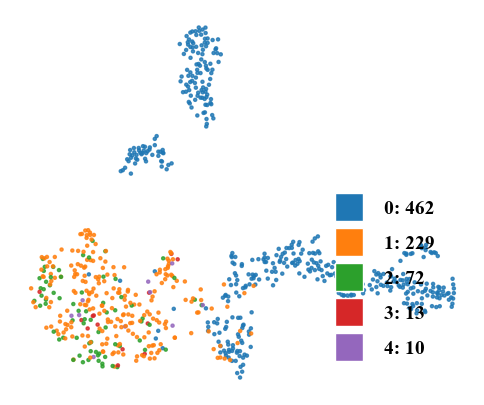

In [18]:
feat_dir ='/home1/wsi/gc-all-features/frozen/gigapath1'
cpt_path = '/home/huangjialong/projects/BiomedCLIP-PUNCE/MIL/output-model/mtl-524/2625_gigapath_oh_5_bce_nonilm/fold_0_model_best_recall.pt'
tsne_abmil(feat_dir, cpt_path, 1536, draw_legend=True)
plt.show()